# KNN with Parameter Tuning

In this project, I wrote up my own k-NN algorithm (with normalization) and implemented it on a dataset of breast cancer data. 
I also implemented my own cross-validation algorithm in order to tune the model parameters before evaluating the classifier on the test set.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import statistics
import random

### Function definitions

In [21]:
def euclidean_distance(p, q):
    sum_cathetus = 0
    for i in range(0, len(p)):
        cathetus = (p[i] - q[i])**2
        sum_cathetus += cathetus
    
    return math.sqrt(sum_cathetus)

def manhattan_distance(p, q):
    sum_manhattan = 0
    for i in range(0, len(p)):
        sum_manhattan += abs(p[i] - q[i])
    return sum_manhattan

    
def knn(x_train, y_train, x_test, k, distance_func):

    x_train_normalized = ((x_train - x_train.min()) / (x_train.max() - x_train.min()) )
    x_test_normalized = ((x_test - x_train.min()) / (x_train.max() - x_train.min()) )

    predictions = []
    for row, query_point in x_test_normalized.iterrows():
        distances = []
        labels = []

        #Get distances between each x_train point and the query point
        for index in range(0, len(x_train_normalized)):
            d = distance_func(x_train_normalized.iloc[index], query_point)
            distances.append((d,index))
        distances = sorted(distances)

        k_nearest_neighbors = distances[0:k]

        #Getting the labels of y for each neighbor of the query point
        for neighbor in k_nearest_neighbors:
            index = neighbor[1]
            label = y_train['target'].iloc[index]
            labels.append(label)

        prediction = statistics.mode(labels)
        predictions.append(prediction)
        y_predictions = pd.DataFrame(data={'predictions':predictions})

    return y_predictions

def assign_evaluation_metric_label(target, prediction):

    if target == 0 and prediction == 0:
        return 'TN'
    if target == 0 and prediction == 1:
        return 'FP'
    if target == 1 and prediction == 0:
        return 'FN'
    if target == 1 and prediction == 1:
        return 'TP'
    
def evaluate_model(y_test, y_predictions):
    y_test_predictions_concat = pd.concat([y_test, y_predictions], axis=1)
    evaluation_metric_labels = list(y_test_predictions_concat.apply(lambda row: assign_evaluation_metric_label(row['target'], row['predictions']), axis=1))
    tp = evaluation_metric_labels.count('TP')
    fp = evaluation_metric_labels.count('FP')
    fn = evaluation_metric_labels.count('FN')
    tn = evaluation_metric_labels.count('TN')
    recall = tp/(tp+fn) if tp != 0 or fn != 0 else 0
    precision = tp/(tp+fp) if tp != 0 or fp != 0 else 0
    fpr = fp/(fp + tn) if fp != 0 or tn != 0 else 0
    f1_score = 2*((precision*recall)/(precision+recall)) if precision + recall != 0 else 0
    accuracy = (tp + tn)/y_test_predictions_concat.shape[0]
    conf_matrix = np.array([[tp, fp],
                       [fn, tn]])
    
    return  conf_matrix, recall, precision, fpr, f1_score, accuracy

def cross_validation(x_train, y_train, k_values, number_of_folds, distance_func):
    random_seed = 23
    fold_assignments = pd.DataFrame(columns=['assignments'], index=range(x_train.shape[0]))
    fold_size = len(x_train) // number_of_folds
    begin = 0
    end = fold_size
    for i in range(1,number_of_folds+1):
        fold_assignments.iloc[begin:end, [0]] = i
        begin += fold_size
        end += fold_size
    # fold_assignments = fold_assignments.sample(frac=1, random_state=random_seed, replace=False).reset_index(drop=True)
    
    k_evaluation_metrics_df = pd.DataFrame(columns=[str(k) for k in k_values], index=range(1, number_of_folds+1))
    for i in range(1, number_of_folds+1):
        x_validation_fold = x_train[fold_assignments['assignments'] == i]
        y_validation_fold = y_train[fold_assignments['assignments'] == i]
        x_train_folds = x_train[fold_assignments['assignments'] != i]
        y_train_folds = y_train[fold_assignments['assignments'] != i]

        x_validation_fold.reset_index(drop=True, inplace=True)
        y_validation_fold.reset_index(drop=True, inplace=True)
        x_train_folds.reset_index(drop=True, inplace=True)
        y_train_folds.reset_index(drop=True, inplace=True)

        k_evaluation_metrics = []
        for k in k_values:
            # print(x_train_folds.head()['mean radius'],y_train_folds.head(10))
            y_predictions = knn(x_train_folds, y_train_folds, x_validation_fold, k, distance_func)
            # print(y_predictions.head(10))
            conf_matrix, recall, precision, fpr, f1_score, accuracy = evaluate_model(y_validation_fold, y_predictions)
            k_evaluation_metrics.append(f1_score)
        k_evaluation_metrics_df.loc[i] = k_evaluation_metrics

    return k_evaluation_metrics_df



### Verifying if data is imbalanced and splitting dataset into train and test

In [22]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

breast_cancer_train = pd.read_csv("breast_cancer_train.csv")
breast_cancer_test = pd.read_csv("breast_cancer_test.csv")

#Here we verify if the data is imbalanced. If so, we shouldn't use accuracy as oue evaluation metric
print(f"Label proportions:\n{breast_cancer_train['target'].value_counts(normalize=1)}")

x_train = breast_cancer_train.drop('target', axis=1)
y_train = breast_cancer_train[['target']]

x_test = breast_cancer_test.drop('target', axis=1)
y_test = breast_cancer_test[['target']]

print(x_train.columns)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Label proportions:
0    0.657143
1    0.342857
Name: target, dtype: float64
Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')
(455, 30) (455, 1) (114, 30) (114, 1)


### Evaluating k = 31 with Euclidean Distance

In [31]:
y_predictions = knn(x_train, y_train, x_test, 31, euclidean_distance)
conf_matrix, recall, precision, fpr, f1_score, accuracy = evaluate_model(y_test, y_predictions)

print(f' Accuracy: {accuracy}\n Recall: {recall}\n Precision: {precision}\n F1-Score: {f1_score}')

 Accuracy: 0.9385964912280702
 Recall: 0.875
 Precision: 1.0
 F1-Score: 0.9333333333333333


### Running Cross Validation with Euclidean distance and Manhattan distance

In [24]:
functions = [euclidean_distance, manhattan_distance]
k_evaluation_metrics_df_avg_list = []
for f in functions:
    k_evaluation_metrics_df = cross_validation(x_train, y_train, [1,3,7,15,31,63,127], 5, f)
    k_evaluation_metrics_df_avg = k_evaluation_metrics_df.apply(np.mean, axis=0)
    k_evaluation_metrics_df_avg_list.append(k_evaluation_metrics_df_avg)

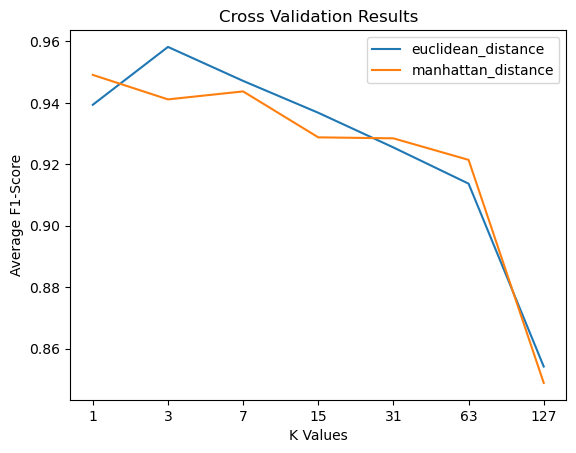

Best Parameters: k=3 with Euclidean distance


In [33]:
for i in range(0, len(k_evaluation_metrics_df_avg_list)):
    plt.plot(k_evaluation_metrics_df_avg_list[i].index, k_evaluation_metrics_df_avg_list[i], label=functions[i].__name__)
plt.xlabel('K Values')
plt.ylabel('Average F1-Score')
plt.title('Cross Validation Results')
plt.legend()
plt.show()

print("Best Parameters: k=3 with Euclidean distance")

### Evaluating classifier on test set using best parameters from cross validation results

In [32]:
y_predictions = knn(x_train, y_train, x_test, k=3, distance_func=euclidean_distance)
conf_matrix, recall, precision, fpr, f1_score, accuracy = evaluate_model(y_test, y_predictions)

print(f' Accuracy: {accuracy}\n Recall: {recall}\n Precision: {precision}\n F1-Score: {f1_score}')

 Accuracy: 0.9649122807017544
 Recall: 0.9464285714285714
 Precision: 0.9814814814814815
 F1-Score: 0.9636363636363636
